In [85]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import lightgbm as lgb

In [86]:
def resample_and_interpolate(group):
    return group.reset_index(level=[1, 2]).resample('30T').asfreq().interpolate()

In [87]:
weather_df = pd.read_csv('D:/Users/paulh/Desktop/Domäneprojekt2/Energy_production_price_prediction/weather_data/DWD_ICON-EU.csv')
solar_total = pd.read_csv('D:/Users/paulh/Desktop/Domäneprojekt2/Energy_production_price_prediction/basic_files/solar_total_production.csv')
solar_total.generation_mw = solar_total.generation_mw * 0.5
weather_df.sort_values(by='ref_datetime', inplace=True)
weather_df = weather_df.groupby(["valid_datetime","latitude","longitude"]).last().reset_index()
weather_df.reset_index(inplace=True)

In [88]:
weather_df.valid_datetime = pd.to_datetime(weather_df.valid_datetime)
weather_df = weather_df.set_index(["valid_datetime","latitude","longitude"])
df_resampled = weather_df.groupby(['latitude', 'longitude'], group_keys=False).apply(resample_and_interpolate)
df_resampled = df_resampled.reset_index()

C:\Users\paulh\AppData\Local\Temp\ipykernel_480\2834871732.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  return group.reset_index(level=[1, 2]).resample('30T').asfreq().interpolate()
C:\Users\paulh\AppData\Local\Temp\ipykernel_480\2834871732.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  return group.reset_index(level=[1, 2]).resample('30T').asfreq().interpolate()
C:\Users\paulh\AppData\Local\Temp\ipykernel_480\2834871732.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  return group.reset_index(level=[1, 2]).resample('30T').asfreq().interpolate()
C:\Users\paulh\AppData\Local\Temp\ipykernel_480\2834871

In [89]:
solar_total.timestamp_utc = pd.to_datetime(solar_total.timestamp_utc)
df_resampled.drop(columns=['index','ref_datetime'], inplace=True)
df_resampled_merged = pd.merge(df_resampled, solar_total, how='left', left_on='valid_datetime', right_on='timestamp_utc')
df_resampled_merged_solar = df_resampled_merged.loc[~(df_resampled_merged.latitude == 53.935) & ~(df_resampled_merged.longitude == 1.8645)]

In [90]:
df_resampled_merged_solar1 = df_resampled_merged_solar.groupby("valid_datetime").mean().reset_index()

In [91]:
distinct_lat_lon_pairs = df_resampled_merged_solar[['latitude', 'longitude']].drop_duplicates()

In [92]:
def set_up_solar_features(df):
    df["hour"] = df.valid_datetime.dt.hour
    df["day_of_year"] = df.valid_datetime.dt.dayofyear
    df["cos_day_of_year"] = np.cos(2 * np.pi * df.day_of_year / 365)
    df["cos_hour"] = np.cos(2 * np.pi * df.hour / 24)
    df["Mean_SolarDownwardRadiation"] = df.SolarDownwardRadiation
    df["Mean_Temperature"] = df.Temperature
    df["Std_Temperature"] = df_resampled_merged_solar.groupby("valid_datetime").std().reset_index().Temperature
    df["SolarDownwardRadiation_RW_Mean_30min"] = df.Mean_SolarDownwardRadiation.rolling(window=1, min_periods=1).mean()
    df["SolarDownwardRadiation_RW_Mean_1hour"] = df.Mean_SolarDownwardRadiation.rolling(window=2, min_periods=1).mean()
    df["SolarDownwardRadiation_dwd_Mean_Lag_30min"] = df.Mean_SolarDownwardRadiation.shift(1)
    df["SolarDownwardRadiation_dwd_Mean_Lag_1h"] = df.Mean_SolarDownwardRadiation.shift(2)
    df["SolarDownwardRadiation_dwd_Mean_Lag_24h"] = df.Mean_SolarDownwardRadiation.shift(48)
    for i in range(len(distinct_lat_lon_pairs)):
        lat = distinct_lat_lon_pairs.latitude.iloc[i]
        lon = distinct_lat_lon_pairs.longitude.iloc[i]
        mask = (df_resampled_merged_solar.latitude == lat) & (df_resampled_merged_solar.longitude == lon)
        df[f"Temperature_{i}"] = pd.Series(df_resampled_merged_solar.Temperature[mask].values)[:len(df)]  # Fill gaps with NaN
        df[f"SolarDownwardRadiation_{i}"] = pd.Series(df_resampled_merged_solar.SolarDownwardRadiation[mask].values)[:len(df)]  # Fill gaps with NaN
    return df
df_resampled_merged_solar2 = set_up_solar_features(df_resampled_merged_solar1)

In [93]:
def pv_temperature_efficiency(irradiance, ambient_temp, NOCT=45, wind_speed=1, eta_0=0.18, beta=0.004):
    # Calculate cell temperature using the simplified NOCT model
    Tc = ambient_temp + (NOCT - 20) * (irradiance / 800)
    
    # Calculate the efficiency loss due to increased cell temperature
    efficiency = eta_0 * (1 - beta * (Tc - 25))
    
    return Tc, efficiency

In [94]:
for i in range(20):
    temp_col = f'Temperature_{i}'
    irradiance_col = f'SolarDownwardRadiation_{i}'
    panel_temp_col = f'Panel_Temperature_Point{i}'
    panel_eff_col = f'Panel_Efficiency_Point{i}'
    df_resampled_merged_solar2[panel_temp_col], df_resampled_merged_solar2[panel_eff_col] = pv_temperature_efficiency(df_resampled_merged_solar2[irradiance_col], df_resampled_merged_solar2[temp_col])

In [95]:
df_resampled_merged_solar2["Panel_Temperature_dwd_mean"] = df_resampled_merged_solar2.filter(regex= r"Panel_Temperature.*").mean(axis= 1)
df_resampled_merged_solar2["Panel_Efficiency_dwd_mean"] = df_resampled_merged_solar2.filter(regex= r"Panel_Efficiency.*").mean(axis= 1)
df_resampled_merged_solar2["Panel_Temperature_dwd_std"] = df_resampled_merged_solar2.filter(regex= r"Panel_Temperature.*").std(axis= 1)
df_resampled_merged_solar2["Panel_Efficiency_dwd_std"] = df_resampled_merged_solar2.filter(regex= r"Panel_Efficiency.*").std(axis= 1)

In [96]:
df_resampled_merged_solar2["solar_mw_lag_48h"] = df_resampled_merged_solar2.generation_mw.shift(periods= 96)
df_resampled_merged_solar2["capacity_mwp_lag_48h"] = df_resampled_merged_solar2.capacity_mwp.shift(periods= 96)

In [97]:
df_resampled_merged_solar3 = df_resampled_merged_solar2[[ 
    "Mean_SolarDownwardRadiation",
    "SolarDownwardRadiation_RW_Mean_30min",
    "SolarDownwardRadiation_RW_Mean_1hour",
    "SolarDownwardRadiation_dwd_Mean_Lag_30min",
    "SolarDownwardRadiation_dwd_Mean_Lag_1h",
    "SolarDownwardRadiation_dwd_Mean_Lag_24h",
    "Panel_Efficiency_dwd_mean",
    "Panel_Efficiency_dwd_std",
    "Panel_Temperature_dwd_mean",
    "Panel_Temperature_dwd_std",
    "Std_Temperature",
    "Mean_Temperature",
    "cos_hour",
    "cos_day_of_year","solar_mw_lag_48h","capacity_mwp_lag_48h","generation_mw"]]
df_resampled_merged_solar3.dropna(inplace=True)

C:\Users\paulh\AppData\Local\Temp\ipykernel_480\2348364355.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_merged_solar3.dropna(inplace=True)


In [98]:
X_scaled_light_gbm = df_resampled_merged_solar2[[ 
    "Mean_SolarDownwardRadiation",
    "SolarDownwardRadiation_RW_Mean_1hour",
    "SolarDownwardRadiation_RW_Mean_30min",
    "SolarDownwardRadiation_dwd_Mean_Lag_30min",
    "SolarDownwardRadiation_dwd_Mean_Lag_1h",
    "SolarDownwardRadiation_dwd_Mean_Lag_24h",
    "Panel_Efficiency_dwd_mean",
    "Panel_Efficiency_dwd_std",
    "Panel_Temperature_dwd_mean",
    "Panel_Temperature_dwd_std",
    "Std_Temperature",
    "Mean_Temperature",
    "cos_hour",
    "cos_day_of_year",
    "capacity_mwp_lag_48h",
    "solar_mw_lag_48h",
    "generation_mw"
    ]]
X_scaled_light_gbm.dropna(inplace=True)
Y_light_gbm = X_scaled_light_gbm.generation_mw
X_scaled_light_gbm.drop(columns=["generation_mw"], inplace=True)

C:\Users\paulh\AppData\Local\Temp\ipykernel_480\2274832667.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_scaled_light_gbm.dropna(inplace=True)
C:\Users\paulh\AppData\Local\Temp\ipykernel_480\2274832667.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_scaled_light_gbm.drop(columns=["generation_mw"], inplace=True)


solar

In [99]:
df_resampled_merged_solar3

,Mean_SolarDownwardRadiation,SolarDownwardRadiation_RW_Mean_30min,SolarDownwardRadiation_RW_Mean_1hour,SolarDownwardRadiation_dwd_Mean_Lag_30min,SolarDownwardRadiation_dwd_Mean_Lag_1h,SolarDownwardRadiation_dwd_Mean_Lag_24h,Panel_Efficiency_dwd_mean,Panel_Efficiency_dwd_std,Panel_Temperature_dwd_mean,Panel_Temperature_dwd_std,Std_Temperature,Mean_Temperature,cos_hour,cos_day_of_year,solar_mw_lag_48h,capacity_mwp_lag_48h,generation_mw
96,0.0,0.0,0.0,0.0,0.0,0.0,0.188081,0.000357,13.776000,0.496404,0.337606,13.58750,1.000000,0.158559,0.0,2779.542388,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.188098,0.000327,13.753000,0.454666,0.349814,13.48025,1.000000,0.158559,0.0,2779.542384,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.188098,0.000327,13.753000,0.454666,0.370293,13.37300,0.965926,0.158559,0.0,2779.542383,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0,0.188134,0.000287,13.702750,0.399291,0.364783,13.32325,0.965926,0.158559,0.0,2779.542370,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.188134,0.000287,13.702750,0.399291,0.362641,13.27350,0.866025,0.158559,0.0,2779.542348,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,0.0,0.0,0.0,0.0,0.0,0.0,0.186083,0.000531,16.551234,0.737510,0.521161,6.64250,0.707107,0.242850,0.0,2779.218524,0.0
343,0.0,0.0,0.0,0.0,0.0,0.0,0.185100,0.000825,17.916750,1.145369,0.556076,6.72100,0.707107,0.242850,0.0,2779.218512,0.0
344,0.0,0.0,0.0,0.0,0.0,0.0,0.185474,0.000665,17.397836,0.923327,0.602857,6.79950,0.500000,0.242850,0.0,2779.218480,0.0
345,0.0,0.0,0.0,0.0,0.0,0.0,0.185847,0.000667,16.878922,0.926172,0.678056,6.93050,0.500000,0.242850,0.0,2779.218479,0.0


In [100]:
#load scaler and model
import pickle
from sklearn.preprocessing import StandardScaler

scaler = pickle.load(open('D:/Users/paulh/Desktop/Domäneprojekt2/Energy_production_price_prediction/paul_analyse/scaler.pkl', 'rb'))
X = df_resampled_merged_solar3.drop(columns=["generation_mw"])
X_scaled = scaler.transform(X)
Y = df_resampled_merged_solar3.generation_mw
Y = Y

c:\Users\paulh\anaconda3\envs\HEFTcom24\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [101]:
X_scaled_light_gbm

,Mean_SolarDownwardRadiation,SolarDownwardRadiation_RW_Mean_1hour,SolarDownwardRadiation_RW_Mean_30min,SolarDownwardRadiation_dwd_Mean_Lag_30min,SolarDownwardRadiation_dwd_Mean_Lag_1h,SolarDownwardRadiation_dwd_Mean_Lag_24h,Panel_Efficiency_dwd_mean,Panel_Efficiency_dwd_std,Panel_Temperature_dwd_mean,Panel_Temperature_dwd_std,Std_Temperature,Mean_Temperature,cos_hour,cos_day_of_year,capacity_mwp_lag_48h,solar_mw_lag_48h
96,0.0,0.0,0.0,0.0,0.0,0.0,0.188081,0.000357,13.776000,0.496404,0.337606,13.58750,1.000000,0.158559,2779.542388,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.188098,0.000327,13.753000,0.454666,0.349814,13.48025,1.000000,0.158559,2779.542384,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.188098,0.000327,13.753000,0.454666,0.370293,13.37300,0.965926,0.158559,2779.542383,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0,0.188134,0.000287,13.702750,0.399291,0.364783,13.32325,0.965926,0.158559,2779.542370,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.188134,0.000287,13.702750,0.399291,0.362641,13.27350,0.866025,0.158559,2779.542348,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,0.0,0.0,0.0,0.0,0.0,0.0,0.186083,0.000531,16.551234,0.737510,0.521161,6.64250,0.707107,0.242850,2779.218524,0.0
343,0.0,0.0,0.0,0.0,0.0,0.0,0.185100,0.000825,17.916750,1.145369,0.556076,6.72100,0.707107,0.242850,2779.218512,0.0
344,0.0,0.0,0.0,0.0,0.0,0.0,0.185474,0.000665,17.397836,0.923327,0.602857,6.79950,0.500000,0.242850,2779.218480,0.0
345,0.0,0.0,0.0,0.0,0.0,0.0,0.185847,0.000667,16.878922,0.926172,0.678056,6.93050,0.500000,0.242850,2779.218479,0.0


In [102]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        # Layer sizes from the best trial
        layer_sizes = [256, 448, 192, 96]
        dropout_rates = [0.12338360578207397, 0.2192742565593194, 0.15708417985889997, 0.253419888887539]

        # Define the layers
        self.fc1 = nn.Linear(input_dim, layer_sizes[0])
        self.fc2 = nn.Linear(layer_sizes[0], layer_sizes[1])
        self.fc3 = nn.Linear(layer_sizes[1], layer_sizes[2])
        self.fc4 = nn.Linear(layer_sizes[2], layer_sizes[3])
        self.fc5 = nn.Linear(layer_sizes[3], 9)  # Output layer

        # Dropouts
        self.dropout1 = nn.Dropout(dropout_rates[0])
        self.dropout2 = nn.Dropout(dropout_rates[1])
        self.dropout3 = nn.Dropout(dropout_rates[2])
        self.dropout4 = nn.Dropout(dropout_rates[3])

        # Activation function (Swish)
        self.swish = nn.SiLU()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # First layer with ReLU
        x = self.dropout1(x)         # First dropout
        x = self.swish(self.fc2(x))  # Second layer with Swish
        x = self.dropout2(x)         # Second dropout
        x = self.swish(self.fc3(x))  # Third layer with Swish
        x = self.dropout3(x)         # Third dropout
        x = self.swish(self.fc4(x))  # Fourth layer with Swish
        x = self.dropout4(x)         # Fourth dropout
        x = self.fc5(x)              # Output layer (no activation for raw outputs)
        return x

In [103]:
# import torch
# import torch.nn as nn

# # Define the MLP model
# class MLP(nn.Module):
#     def __init__(self, input_dim):
#         super(MLP, self).__init__()
#         # Single hidden layer with 416 neurons as suggested by Optuna
#         self.fc1 = nn.Linear(input_dim, 416)
#         self.fc2 = nn.Linear(416, 9)  # Output layer with 9 neurons for quantiles
        
#         # Dropout with rate close to Optuna's suggestion
#         self.dropout = nn.Dropout(0.13)
#         self.swish = nn.SiLU()
    
#     def forward(self, x):
#         x = self.swish(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

In [104]:
# Load the model from the file
model = MLP(X_scaled.shape[1])
model.load_state_dict(torch.load('D:/Users/paulh/Desktop/Domäneprojekt2/Energy_production_price_prediction/paul_analyse/model1.pth'))

C:\Users\paulh\AppData\Local\Temp\ipykernel_480\2147376376.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('D:/Users/paulh/Desktop/Domän

<All keys matched successfully>

In [119]:
#make predictions
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
model.eval()
with torch.no_grad():
    predictions = model(X_tensor).numpy()

predictions

array([[-7.5107724e-03, -9.4377175e-03, -6.0683042e-03, ...,
         7.4760523e-03,  2.3126490e-02,  7.6928213e-02],
       [-7.5884098e-03, -9.5284618e-03, -6.1451886e-03, ...,
         7.3960554e-03,  2.3080979e-02,  7.7015556e-02],
       [-7.8472141e-03, -9.8134251e-03, -6.3369051e-03, ...,
         7.0963427e-03,  2.2668321e-02,  7.6370224e-02],
       ...,
       [-4.8347912e-03, -2.0619977e-02, -2.7194506e-02, ...,
        -1.5154446e-02,  4.7614317e-02,  2.0398124e-01],
       [-5.8886572e-03, -1.9234240e-02, -2.3749473e-02, ...,
        -2.4582092e-03,  6.1221231e-02,  2.1738636e-01],
       [ 2.1458815e-01,  4.4440401e-01,  6.7484176e-01, ...,
         1.7716066e+00,  2.2682340e+00,  3.0986269e+00]], dtype=float32)

In [120]:
predictions.shape

(248, 9)

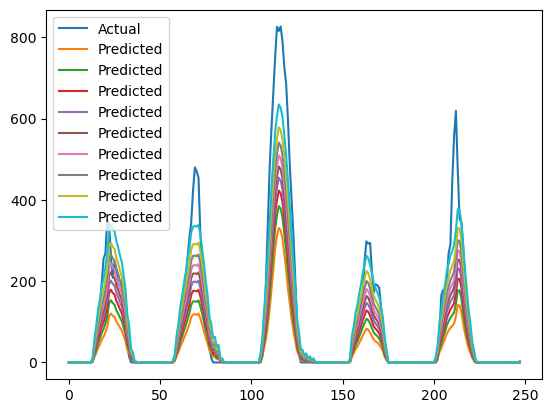

In [106]:
#compare predictions with actual values
import matplotlib.pyplot as plt

plt.plot(Y.values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()


In [121]:
predictions[:,4]

array([ 9.22901556e-04,  8.45825300e-04,  6.24965876e-04,  5.67432493e-04,
        1.93448737e-04,  1.59606338e-04,  3.78545374e-05,  4.45153564e-05,
        3.23746353e-04,  3.33035365e-04,  2.41206959e-03,  3.16254050e-03,
       -4.94614430e-03,  4.07766628e+00,  3.15990543e+01,  5.19946404e+01,
        7.67074127e+01,  9.25563889e+01,  1.13449448e+02,  1.27362267e+02,
        1.46324875e+02,  1.68819000e+02,  2.12750351e+02,  2.22051041e+02,
        2.13281631e+02,  2.08159332e+02,  1.90666092e+02,  1.78777603e+02,
        1.65223938e+02,  1.53309387e+02,  1.30949570e+02,  1.08539856e+02,
        6.74100037e+01,  4.99204216e+01,  1.73235722e+01,  1.19802961e+01,
        1.22048271e+00,  7.17209697e-01,  4.80061397e-04,  1.00664794e-04,
        9.73530114e-05,  1.17154792e-04,  8.20662826e-05,  2.65676528e-04,
        2.74606049e-04,  4.34637070e-04,  4.26970422e-04,  3.08668241e-04,
        3.49605456e-04,  1.37435272e-04,  1.74529850e-04,  2.02102587e-04,
        2.36751512e-04,  

In [109]:
#pinball loss on test data
def pinball_loss(y_true, y_pred, quantile):
    delta = y_true - y_pred
    return np.mean(np.maximum(quantile * delta, (quantile - 1) * delta))

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
losses = [pinball_loss(Y.values, predictions[:, i], quantiles[i]) for i in range(9)]
losses

[7.420323059389237,
 12.84628610344647,
 17.036562962896266,
 20.138651206156737,
 22.326747420627658,
 23.506773775416598,
 23.230419736581506,
 21.338214933814637,
 16.249472546487958]

In [50]:
#average error
error = np.mean(np.abs(predictions[:,4] - Y.values))
error

44.653494841255316

In [58]:
def modified_pinball_loss(y_true, y_pred, quantile):
    delta = y_true - y_pred
    return np.mean(np.maximum(quantile * delta, (quantile - 1) * delta))

In [84]:
path = "D:/Users/paulh/Desktop/Domäneprojekt2/Energy_production_price_prediction/Generation_forecast/Solar_forecast/models/lgbr_model/models/i4_models/lgbr_q"
quantiles = [1, 2, 3, 4, 5, 6, 7, 8, 9]
for i in quantiles:
    model_light = pickle.load(open(path + str(i) + ".pkl", 'rb'))
    predictions = model_light.predict(X_scaled_light_gbm)
    loss = modified_pinball_loss(Y.values, predictions, i/10)
    print(f"Quantile {i/10}: {loss}")

Quantile 0.1: 5.192951198293535
Quantile 0.2: 6.257203708222135
Quantile 0.3: 10.380814374602606
Quantile 0.4: 13.178456146170506
Quantile 0.5: 14.3607415880686
Quantile 0.6: 17.28017948739111
Quantile 0.7: 14.928736444902407
Quantile 0.8: 11.249326079310297
Quantile 0.9: 9.927936913903599


In [125]:
#ensemble light gbm MLP
quantiles = [1, 2, 3, 4, 5, 6, 7, 8, 9]
for i in quantiles:
    model_light = pickle.load(open(path + str(i) + ".pkl", 'rb'))
    predictions_light = model_light.predict(X_scaled_light_gbm)
    predictions_mlp = predictions[:, i - 1]
    predictions_together = (predictions_light + predictions_mlp) / 2
    loss = modified_pinball_loss(Y.values, predictions_together, i/10)
    print(f"Quantile {i/10}: {loss}")


Quantile 0.1: 6.268431983658655
Quantile 0.2: 9.377551357935728
Quantile 0.3: 13.527005868468805
Quantile 0.4: 16.513579147288574
Quantile 0.5: 17.993653869998113
Quantile 0.6: 20.01668260363154
Quantile 0.7: 18.733817941433948
Quantile 0.8: 15.384034442376098
Quantile 0.9: 12.394709585991636


In [124]:
predictions.shape

(248, 9)

In [123]:
predictions[:,0]

array([-7.51077244e-03, -7.58840982e-03, -7.84721412e-03, -7.89280795e-03,
       -8.35885480e-03, -8.39578733e-03, -8.73092003e-03, -8.73678830e-03,
       -8.73866584e-03, -8.73721577e-03, -8.94524250e-03, -9.09274817e-03,
        9.38260835e-03,  1.20034897e+00,  1.34834194e+01,  2.36454048e+01,
        3.61474838e+01,  4.46787109e+01,  5.58199005e+01,  6.35176468e+01,
        7.39101334e+01,  8.69730148e+01,  1.14276726e+02,  1.20634590e+02,
        1.14855721e+02,  1.11552460e+02,  1.00484428e+02,  9.33061905e+01,
        8.55384216e+01,  7.84270706e+01,  6.59256973e+01,  5.33916702e+01,
        3.13498173e+01,  2.24399872e+01,  6.81227541e+00,  4.41856098e+00,
        2.19585761e-01,  1.10206895e-01, -8.71351641e-03, -8.74364376e-03,
       -8.74361396e-03, -8.54542851e-03, -8.56065657e-03, -8.27816129e-03,
       -8.22702143e-03, -7.97285885e-03, -7.99657777e-03, -8.17807298e-03,
       -8.18353612e-03, -8.53335392e-03, -8.54000263e-03, -8.72171763e-03,
       -8.72085243e-03, -